In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from pathlib import Path

from allensdk.core.reference_space_cache import ReferenceSpaceCache

%matplotlib widget

In [2]:
output_dir=r"D:\CCF\cache"
reference_space_key = 'annotation/ccf_2022'
resolution = 10
rspc = ReferenceSpaceCache(resolution, reference_space_key, manifest=Path(output_dir) / 'manifest.json')

# get structure tree
# ID 1 is the adult mouse structure graph
tree = rspc.get_structure_tree(structure_graph_id=1) 

#get id_acronym map
id_acronym_map = tree.get_id_acronym_map()

#make reference space object
rsp = rspc.get_reference_space()

#get annotation volume
annotation, meta = rspc.get_annotation_volume()



In [3]:
# ####get the 10um annotation volume!
# #set up structure tree
# oapi = OntologiesApi()
# structure_graph = oapi.get_structures_with_sets([1])  # 1 is the id of the adult mouse structure graph

# # This removes some unused fields returned by the query
# structure_graph = StructureTree.clean_structures(structure_graph)  
# tree = StructureTree(structure_graph)

# #get id_acronym map
# id_acronym_map = tree.get_id_acronym_map()

# # load annotation volume
# ann_file_name=r"D:\CCF\annotation_25.nrrd"
# data_array, metadata = nrrd.read(ann_file_name)

# #load average template
# template_filename=r"D:\CCF\average_template_25.nrrd"
# readdata, header = nrrd.read(template_filename)

# #make reference space object
# rsp = ReferenceSpace(tree, data_array, 25)


## examples using the atlas

In [3]:
#neuron's ccf coordinate:
#(A/P, D/V, M/L)
coord=(500, 200, 400)
struct_id=annotation[coord]
struct_info=tree.get_structures_by_id([struct_id])

struct_info

[{'acronym': 'MOp6a',
  'graph_id': 1,
  'graph_order': 22,
  'id': 844,
  'name': 'Primary motor area, Layer 6a',
  'structure_id_path': [997, 8, 567, 688, 695, 315, 500, 985, 844],
  'structure_set_ids': [667481449, 184527634, 12, 691663206],
  'rgb_triplet': [31, 157, 90]}]

In [6]:
parents=tree.parents([struct_id])
parents

[{'acronym': 'MOp',
  'graph_id': 1,
  'graph_order': 18,
  'id': 985,
  'name': 'Primary motor area',
  'structure_id_path': [997, 8, 567, 688, 695, 315, 500, 985],
  'structure_set_ids': [112905828,
   688152357,
   691663206,
   687527945,
   12,
   184527634,
   167587189,
   112905813,
   114512891,
   114512892],
  'rgb_triplet': [31, 157, 90]}]

In [7]:
parent_mask = rsp.make_structure_mask([parents[0]['id']])
structure_mask = rsp.make_structure_mask([struct_id])

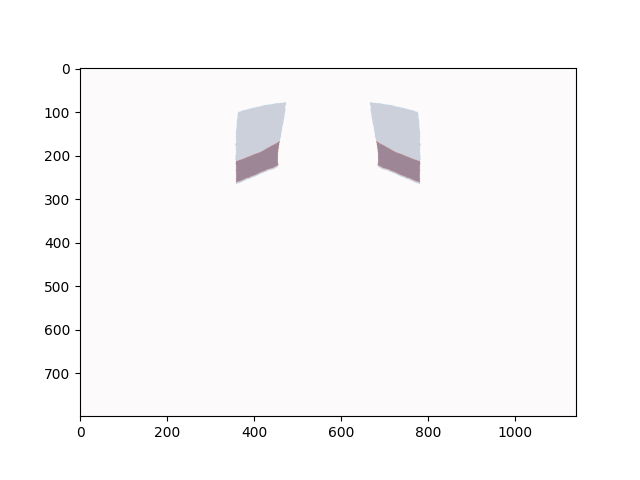

In [8]:
#plot structure mask
fig,ax=plt.subplots(1,1)
ax.imshow(parent_mask[coord[0],:,:],cmap='Blues',alpha=0.3)
ax.imshow(structure_mask[coord[0],:,:],cmap='Reds',alpha=0.3)

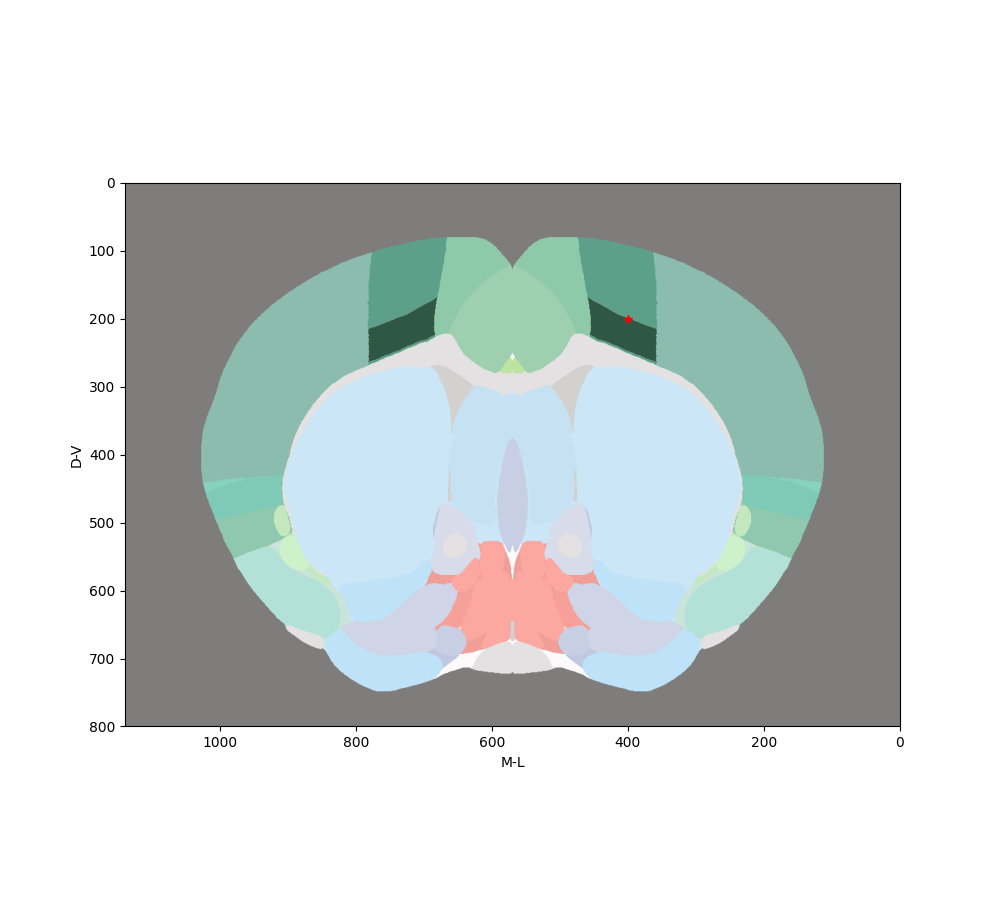

In [11]:
#plot coronal section
#coronal slice at neuron's location
data = rsp.get_slice_image(0, coord[0]*10)

fig = plt.figure(figsize=(10,9))
ax=plt.subplot(1,1,1)
ax.imshow(data,extent=[1140,0,800,0]) 
ax.imshow(parent_mask[coord[0],:,:],cmap='Blues',alpha=0.3)
ax.imshow(structure_mask[coord[0],:,:],cmap='Reds',alpha=0.3)
ax.plot(coord[2],coord[1],'r*')
ax.set_xlabel('M-L')
ax.set_ylabel('D-V')
plt.gca().invert_xaxis() #for some reason necessary to make left=left

## plot decoder accuracy on CCF

In [12]:
#load deocder accuracy by CCF area

ccf_coords_by_session_area=pd.read_csv(r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\new_annotations\linear_shift_20_units\combined\all_unit_linear_shift_use_more_trials.csv")


In [13]:
#make structure mask and collect decoder accuracy for these areas
# structure_list=['MOs','MOp','SS','ORB','FRP','ACA','ILA','PL','AI','RSP','VIS','AUD','PTLp']
structure_list=['MOs']
# structure_list=['CP']
dprime_threshold=1.5

area_insertions=ccf_coords_by_session_area.query('area.str.startswith(@structure_list[0]) and cross_modal_dprime>@dprime_threshold')
structure_id_list=[id_acronym_map[structure_list[0]]]

if len(structure_list)>1:
    for sel_area in structure_list[1:]:
        area_insertions=pd.concat([area_insertions,ccf_coords_by_session_area.query('area.str.startswith(@sel_area) and cross_modal_dprime>@dprime_threshold')],axis=0)
        structure_id_list.append(id_acronym_map[sel_area])

area_mask=rsp.make_structure_mask(structure_id_list)

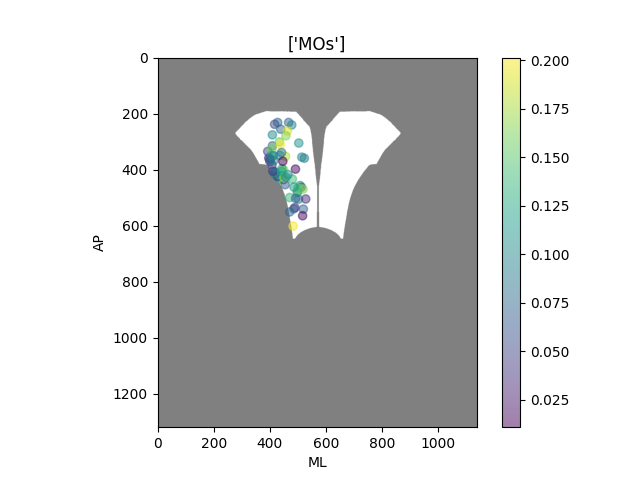

In [14]:
#horizontal view
fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=1),cmap='gray',alpha=0.5)
points=ax.scatter(area_insertions['ccf_ml_mean']/10,area_insertions['ccf_ap_mean']/10,c=area_insertions['true_accuracy']-area_insertions['null_accuracy_median'],alpha=0.5)
ax.set_xlabel('ML')
ax.set_ylabel('AP')
ax.set_title(structure_list)
ax.set_aspect('equal')
fig.colorbar(ax=ax,mappable=points)

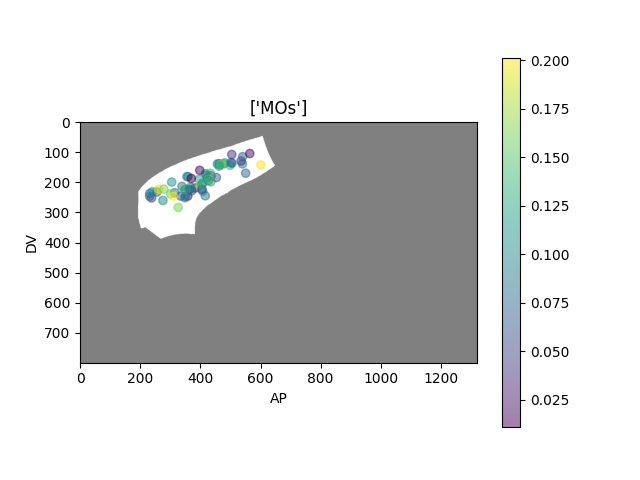

In [15]:
#sagittal view
fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=2).T,cmap='gray',alpha=0.5)
points=ax.scatter(area_insertions['ccf_ap_mean']/10,area_insertions['ccf_dv_mean']/10,c=area_insertions['true_accuracy']-area_insertions['null_accuracy_median'],alpha=0.5)
ax.set_xlabel('AP')
ax.set_ylabel('DV')
ax.set_title(structure_list)
ax.set_aspect('equal')
fig.colorbar(ax=ax,mappable=points)

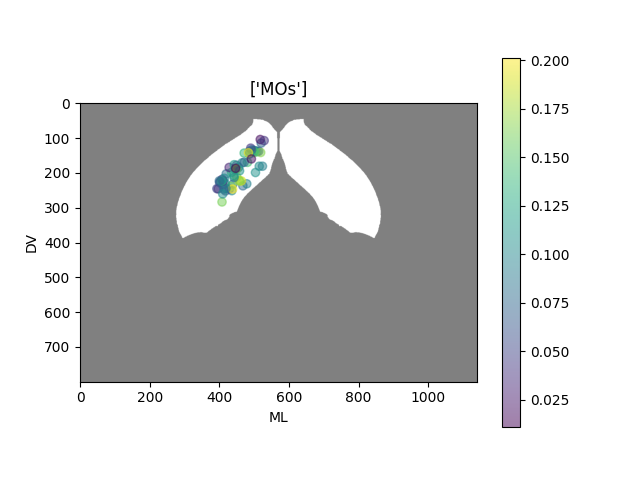

In [16]:
#coronal view
fig,ax=plt.subplots(1,1)
ax.imshow(np.max(area_mask[:,:,:],axis=0),cmap='gray',alpha=0.5)
points=ax.scatter(area_insertions['ccf_ml_mean']/10,area_insertions['ccf_dv_mean']/10,c=area_insertions['true_accuracy']-area_insertions['null_accuracy_median'],alpha=0.5)
ax.set_xlabel('ML')
ax.set_ylabel('DV')
ax.set_title(structure_list)
ax.set_aspect('equal')
fig.colorbar(ax=ax,mappable=points)

## plot decoding results on CCF slices - coronal

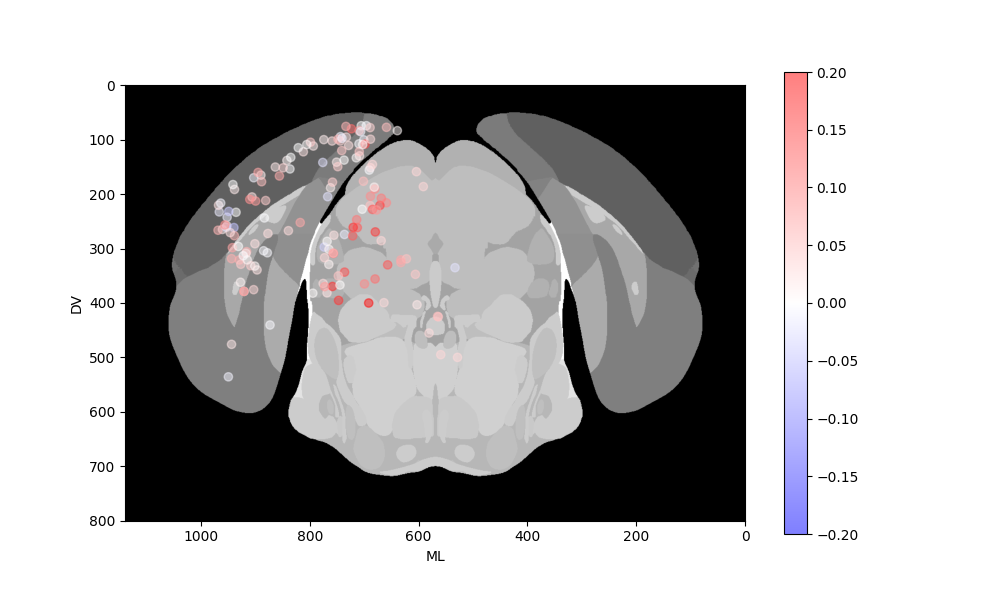

In [17]:
# plot single coronal slice
slice_pos=9500

slice_image= rsp.get_slice_image(0, slice_pos)
results= ccf_coords_by_session_area.query('ccf_ap_mean >= @slice_pos-500 and ccf_ap_mean <= @slice_pos+500')

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
 
gray_image = rgb2gray(slice_image) 

fig = plt.figure(figsize=(10,6))
ax=plt.subplot(1,1,1)
# ax.imshow(data,cmap='gray',extent=[1140,0,800,0]) 
ax.imshow(gray_image,extent=[1140,0,800,0],cmap='gray') 

points=ax.scatter(1140-results['ccf_ml_mean']/10,results['ccf_dv_mean']/10,c=results['true_accuracy']-results['null_accuracy_median'],alpha=0.5,cmap='bwr',vmin=-0.2,vmax=0.2)
ax.set_xlabel('ML')
ax.set_ylabel('DV')
fig.colorbar(ax=ax,mappable=points)

In [69]:
# plot all slices
dprime_thresh=1.0
slice_size=500
slice_pos_array=np.arange(2000+slice_size/2,10500,slice_size)
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-05-21-decoding_topography"

for slice_pos in slice_pos_array:
    slice_image= rsp.get_slice_image(0, slice_pos)
    results= ccf_coords_by_session_area.query('ccf_ap_mean >= @slice_pos-@slice_size/2 and ccf_ap_mean <= @slice_pos+@slice_size/2 and \
                                               cross_modal_dprime>=@dprime_thresh and project=="DynamicRouting" and area!="all"')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig = plt.figure(figsize=(10,6))
    ax=plt.subplot(1,1,1)
    # ax.imshow(data,cmap='gray',extent=[1140,0,800,0]) 
    ax.imshow(gray_image,extent=[1140,0,800,0],cmap='gray') 

    points=ax.scatter(1140-results['ccf_ml_mean']/10,results['ccf_dv_mean']/10,c=results['true_accuracy']-results['null_accuracy_median'],alpha=0.5,cmap='bwr',vmin=-0.2,vmax=0.2)
    ax.set_xlabel('ML')
    ax.set_ylabel('DV')
    fig.colorbar(ax=ax,mappable=points,label='decoder accuracy above null')
    fig.suptitle('slice center: '+str(int(slice_pos))+' ; range: +/-'+str(int(slice_size/2))+'; dprime>='+str(dprime_thresh))

    # filesavepath=os.path.join(savepath,'coronal_slice_'+str(int(slice_pos))+'.png')
    # plt.savefig(filesavepath,dpi=300)
    # plt.close(fig)

## plot decocer results on CCF - horizontal

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_3180\3945925765.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,6))


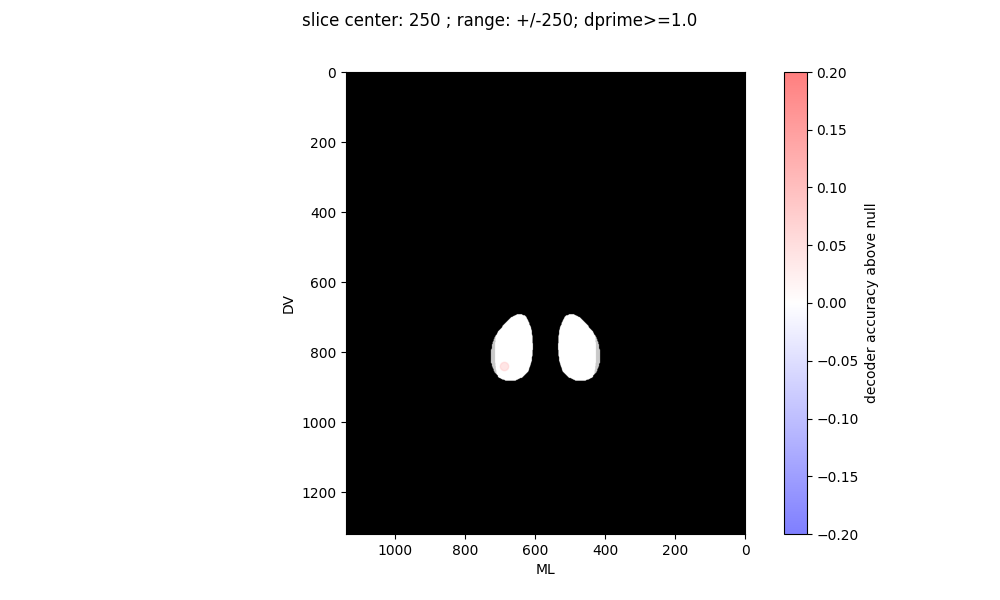

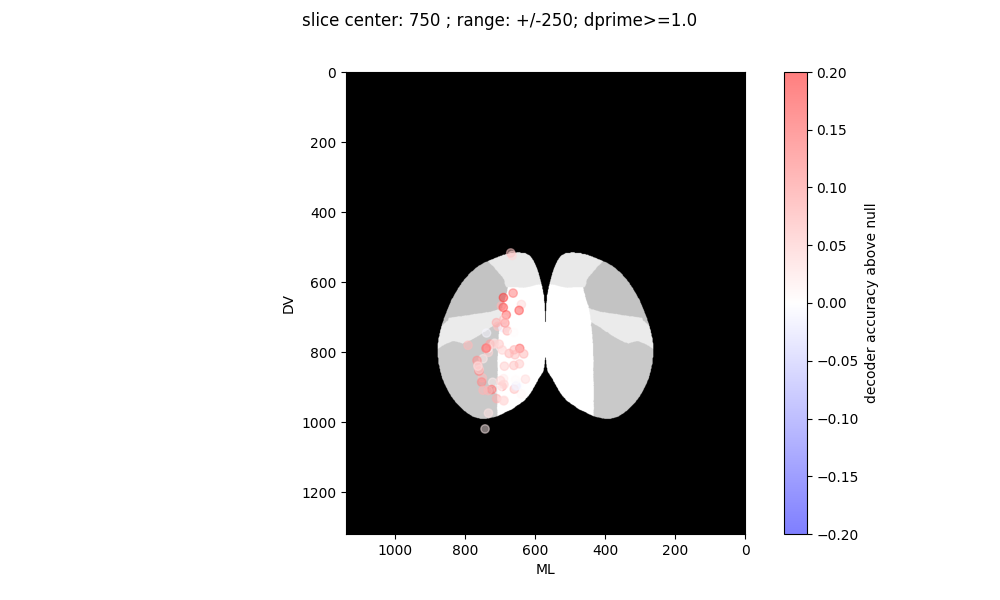

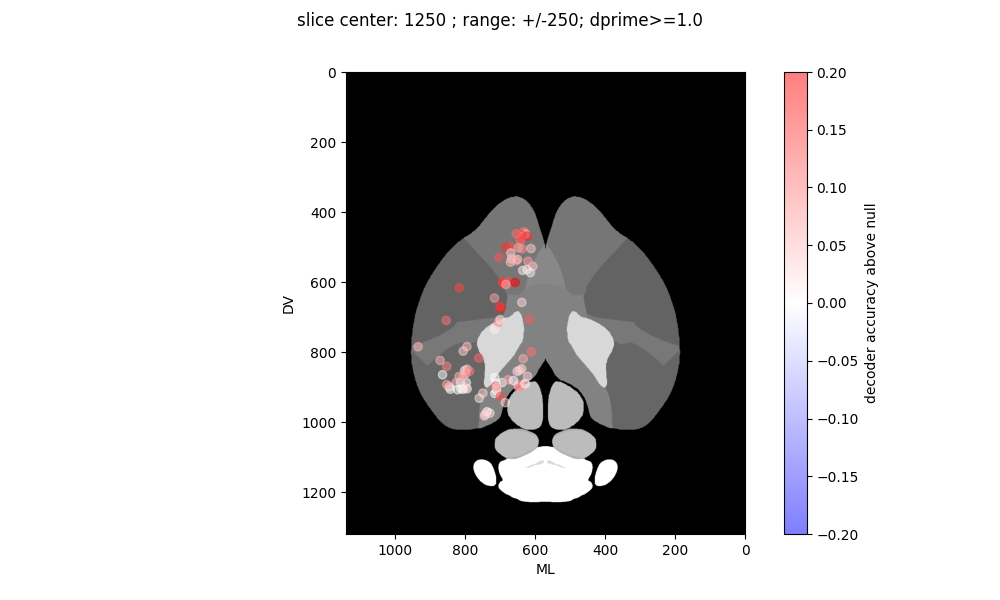

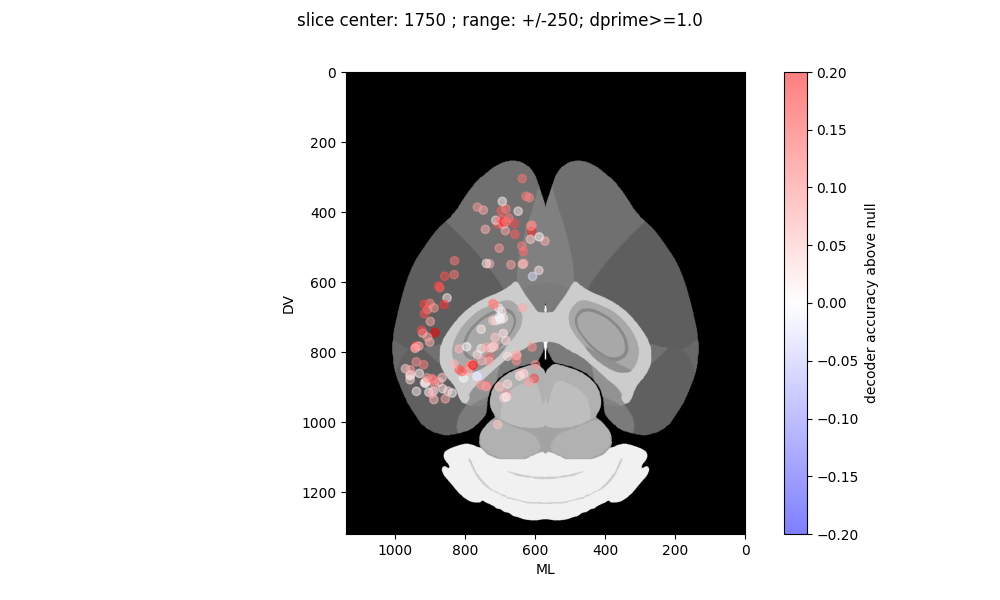

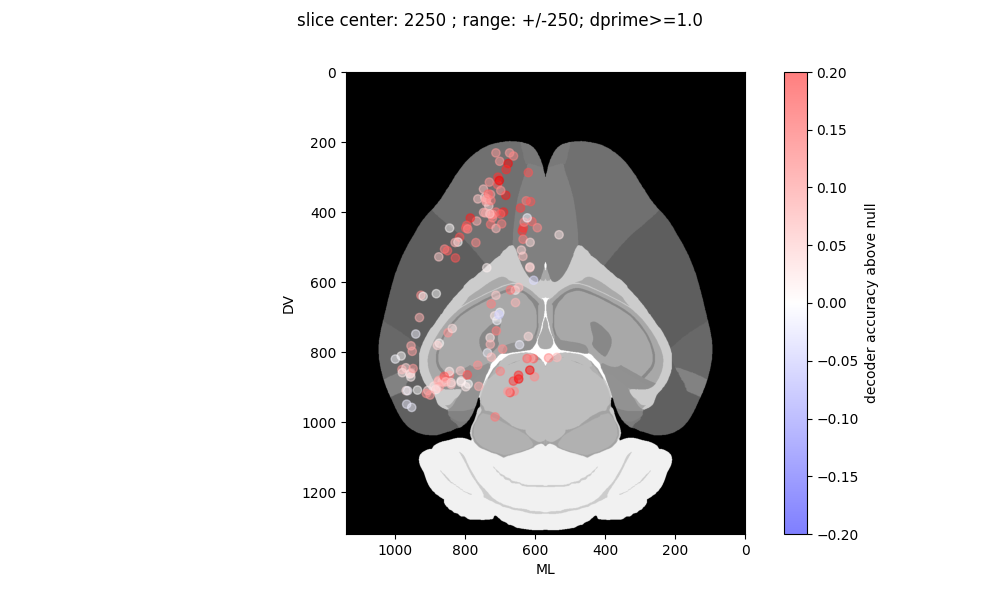

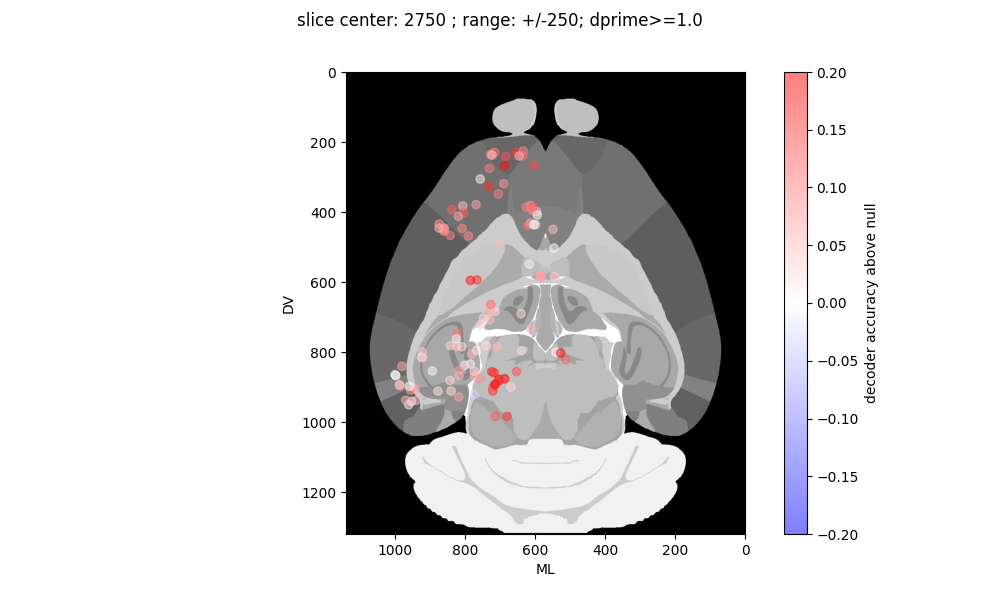

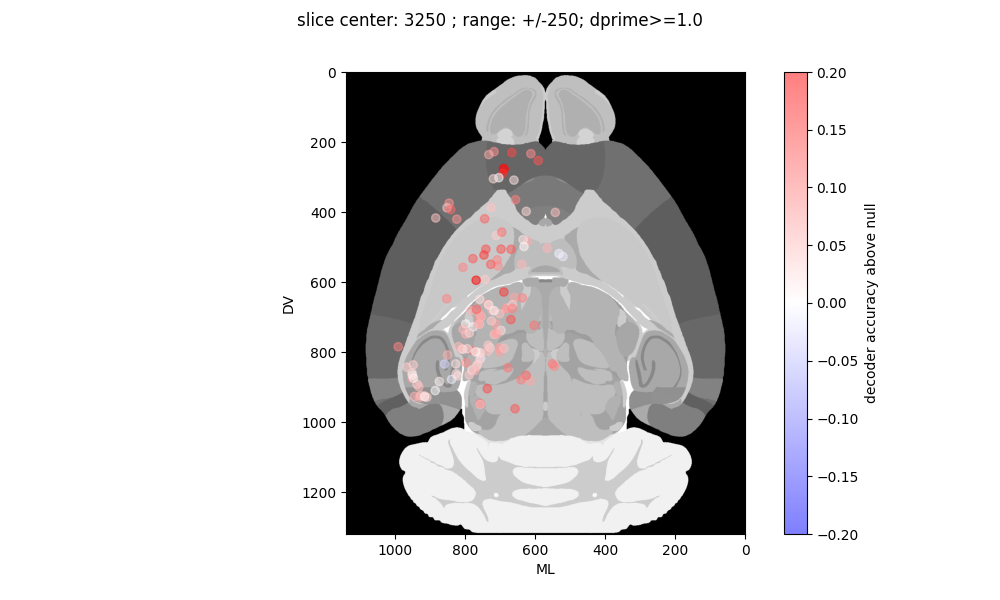

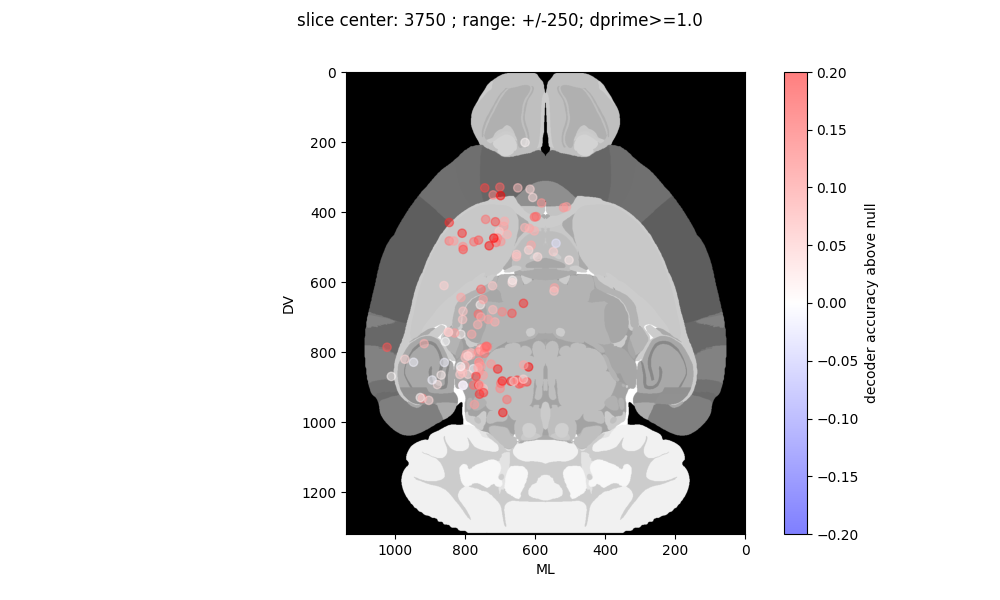

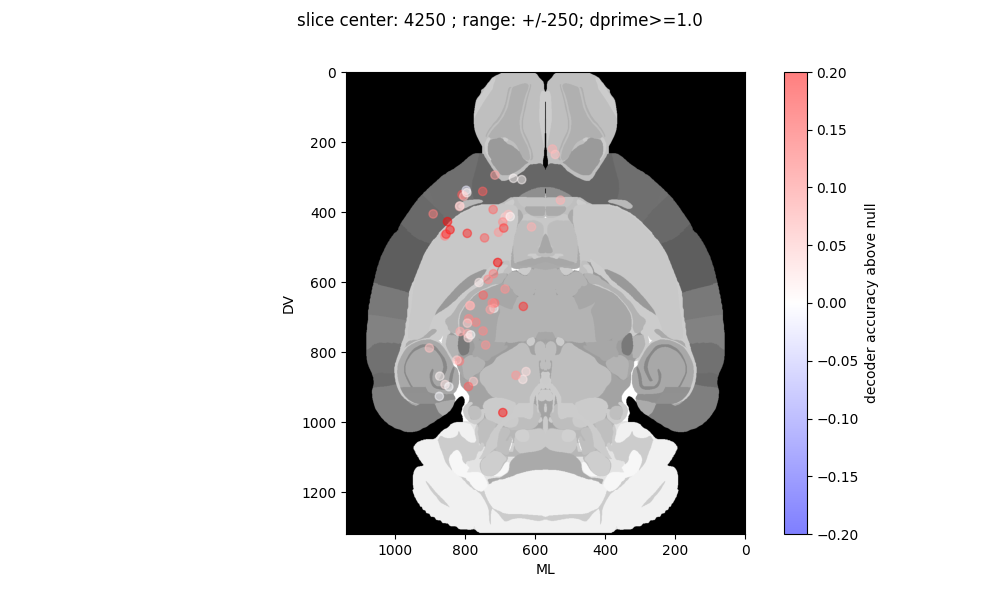

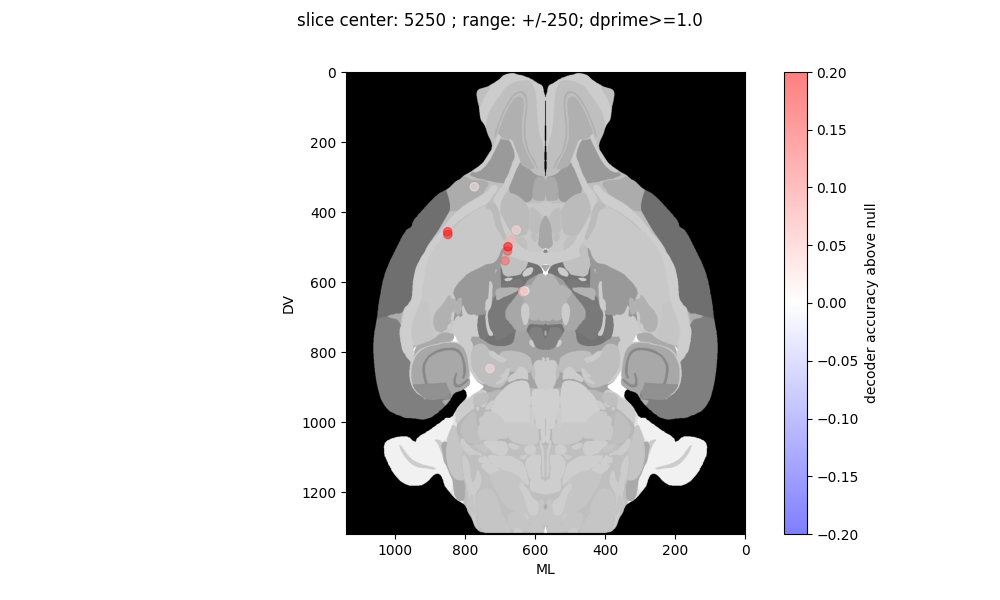

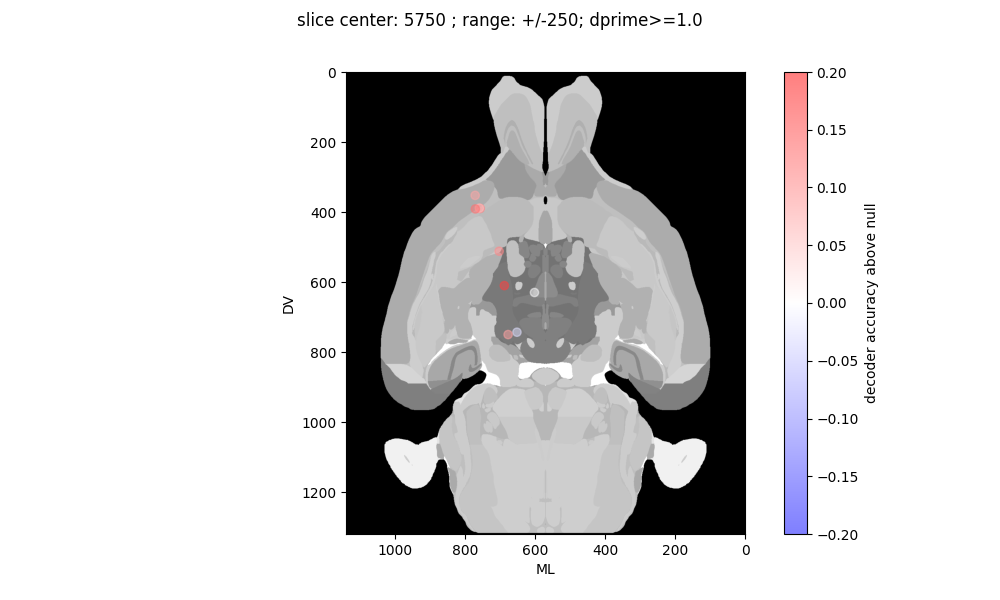

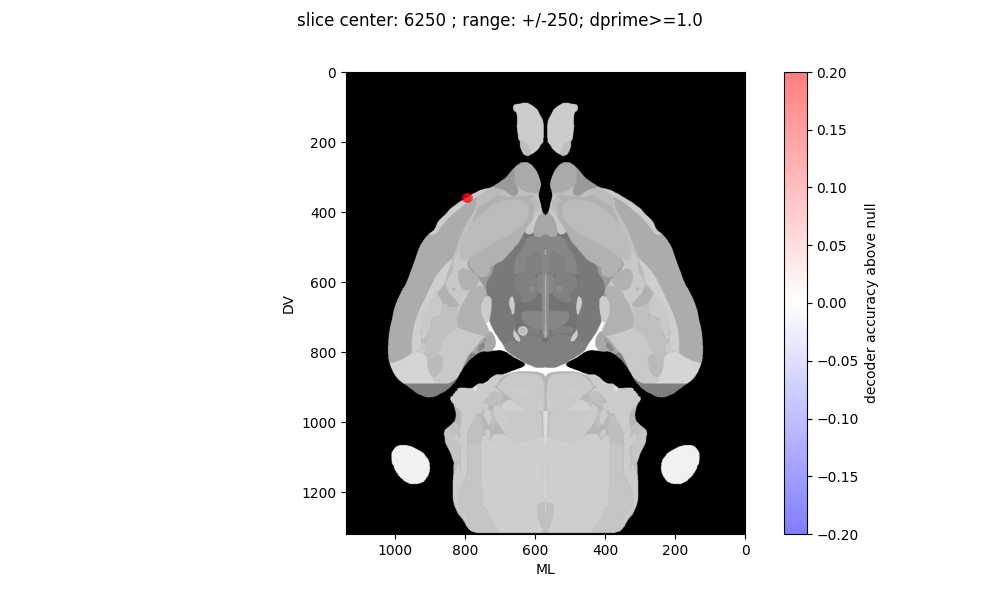

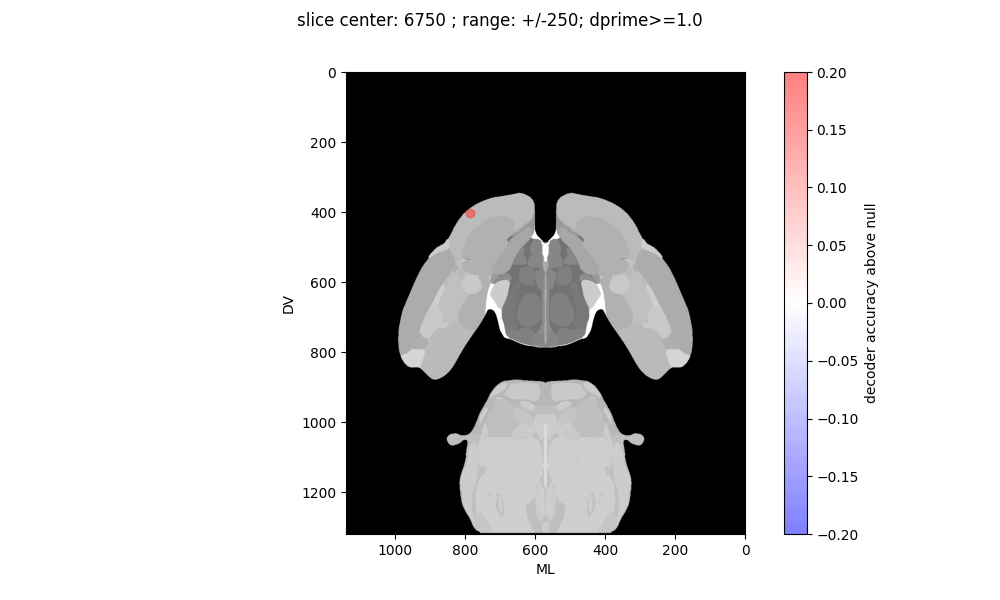

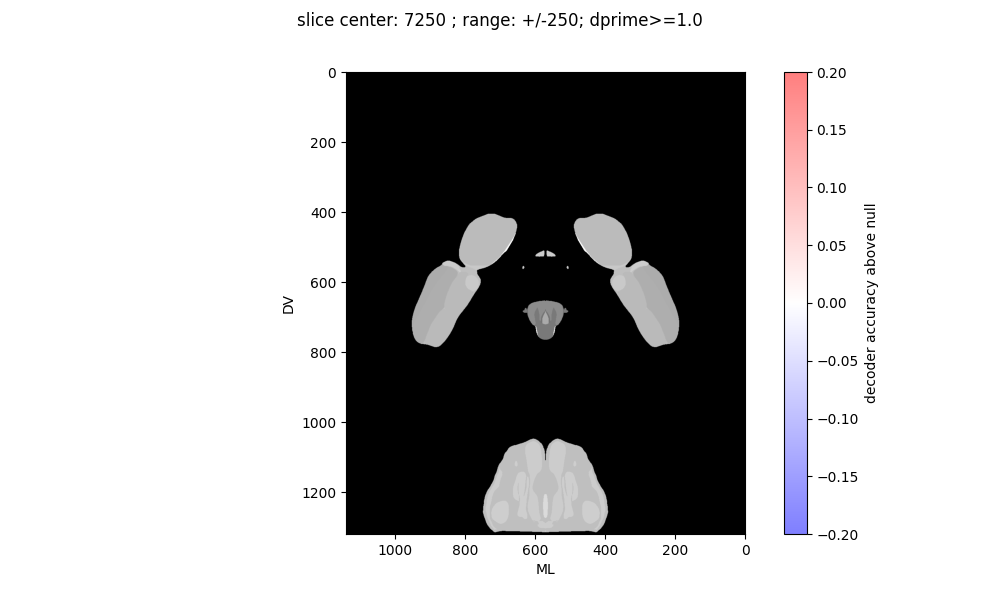

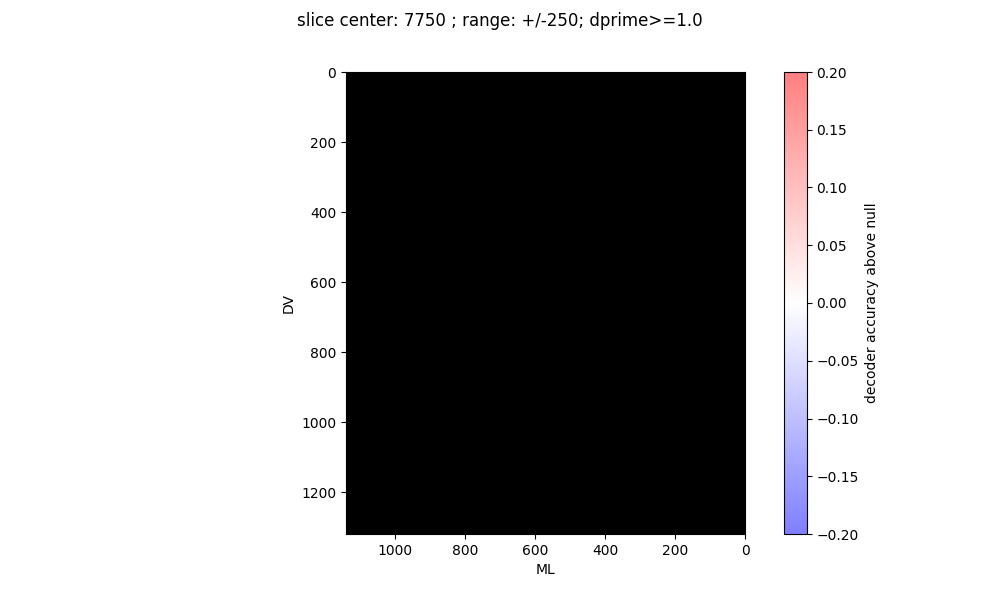

In [19]:
# plot all slices
dprime_thresh=1.0
slice_size=500
slice_pos_array=np.arange(slice_size/2,8000+slice_size/2,slice_size)
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-05-21-decoding_topography"

for slice_pos in slice_pos_array:
    slice_image= rsp.get_slice_image(1, slice_pos)
    results= ccf_coords_by_session_area.query('ccf_dv_mean >= @slice_pos-@slice_size/2 and ccf_dv_mean <= @slice_pos+@slice_size/2 and \
                                               cross_modal_dprime>=@dprime_thresh and project=="DynamicRouting" and area!="all"')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig = plt.figure(figsize=(10,6))
    ax=plt.subplot(1,1,1)
    ax.imshow(gray_image,extent=[1140,0,1320,0],cmap='gray') 

    points=ax.scatter(1140-results['ccf_ml_mean']/10,results['ccf_ap_mean']/10,c=results['true_accuracy']-results['null_accuracy_median'],alpha=0.5,cmap='bwr',vmin=-0.2,vmax=0.2)
    ax.set_xlabel('ML')
    ax.set_ylabel('DV')
    fig.colorbar(ax=ax,mappable=points,label='decoder accuracy above null')
    fig.suptitle('slice center: '+str(int(slice_pos))+' ; range: +/-'+str(int(slice_size/2))+'; dprime>='+str(dprime_thresh))

    # filesavepath=os.path.join(savepath,'horizontal_slice_'+str(int(slice_pos))+'.png')
    # plt.savefig(filesavepath,dpi=300)
    # plt.close(fig)

## plot decoder results on CCF - sagittal

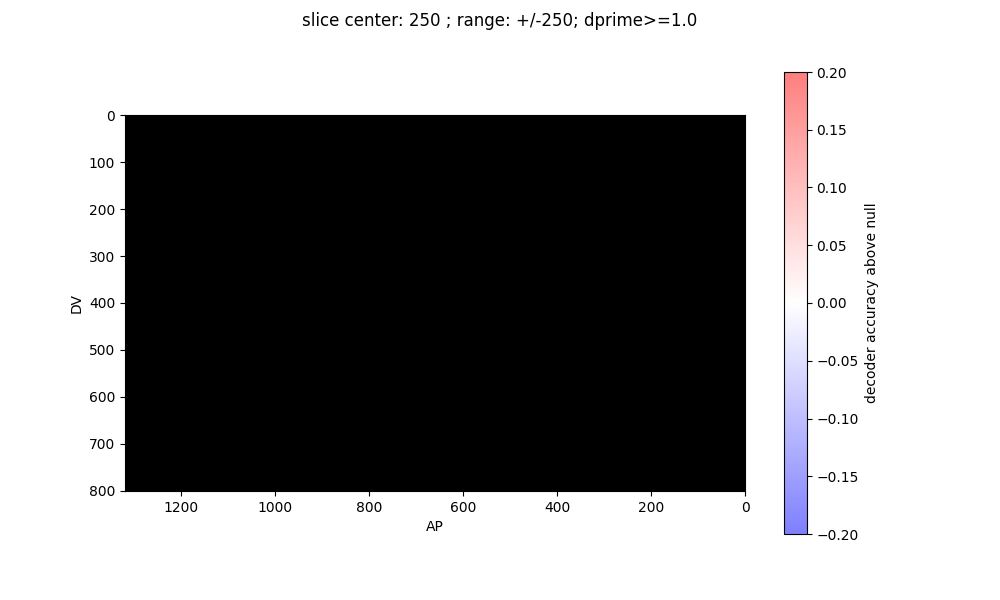

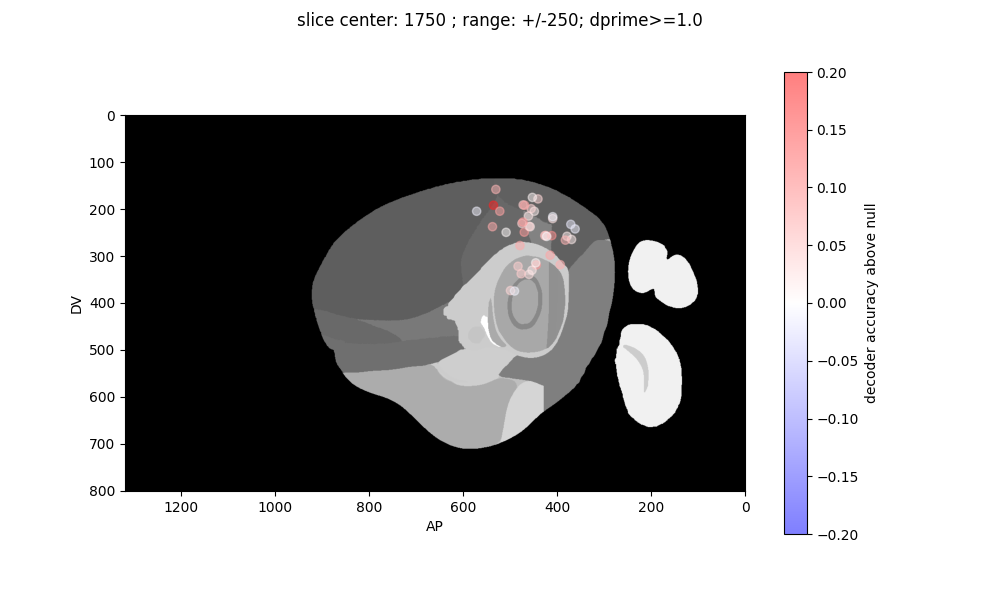

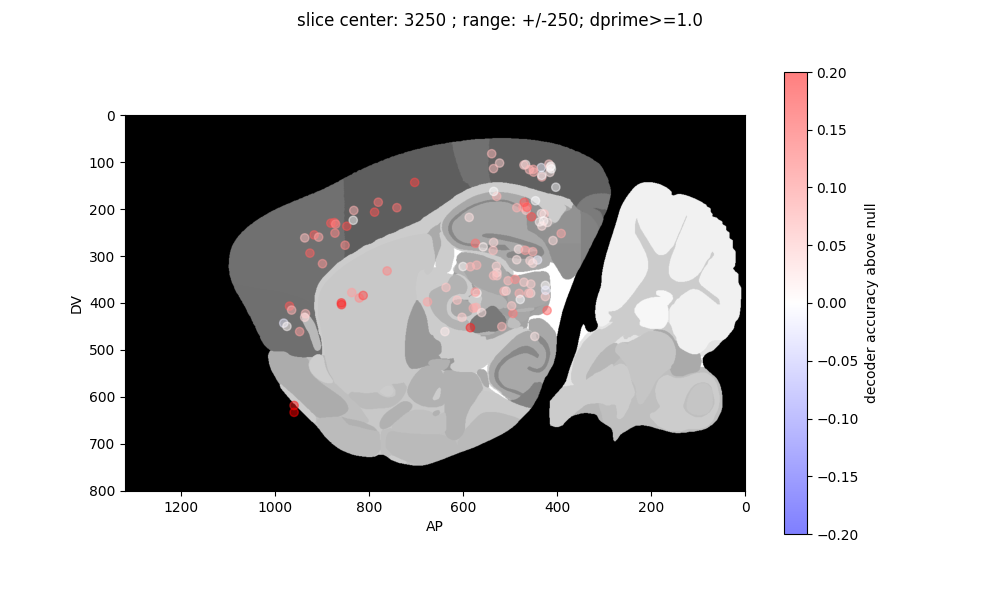

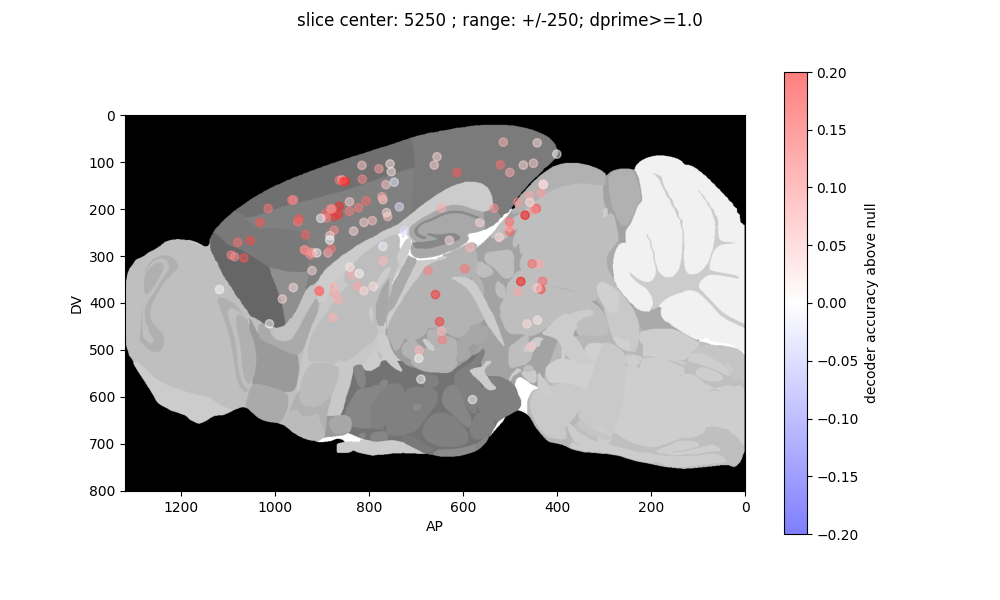

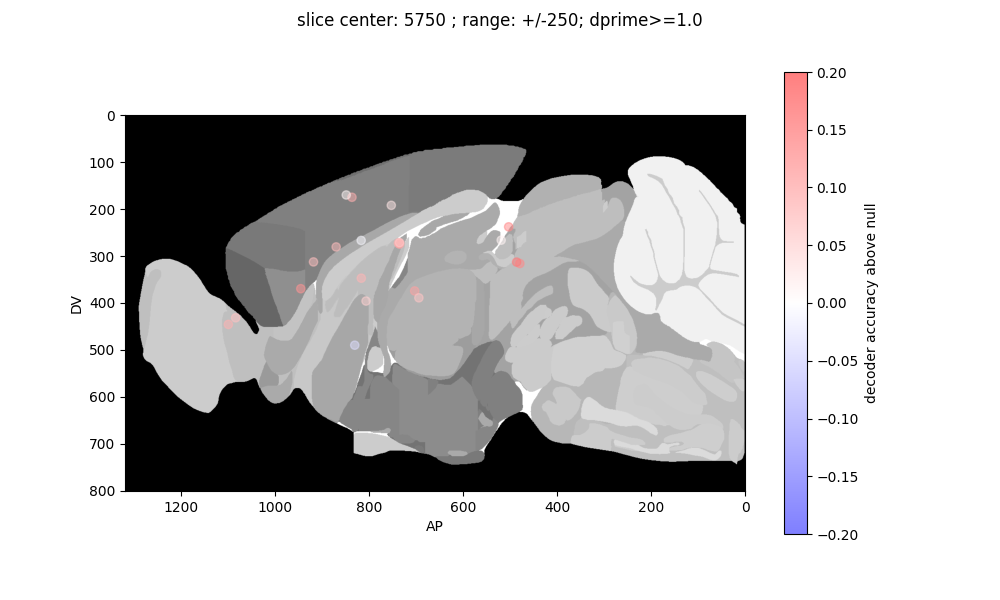

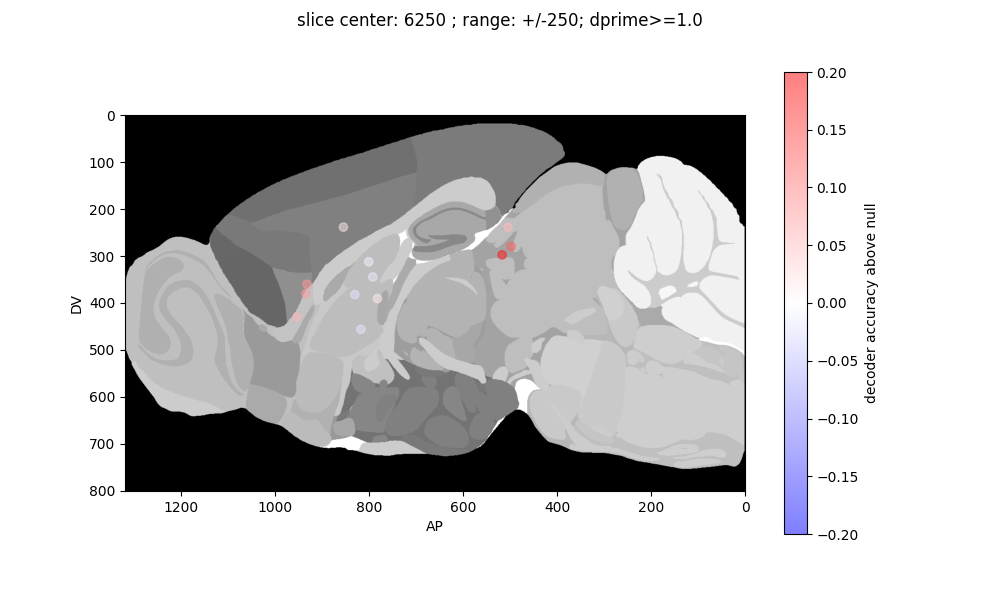

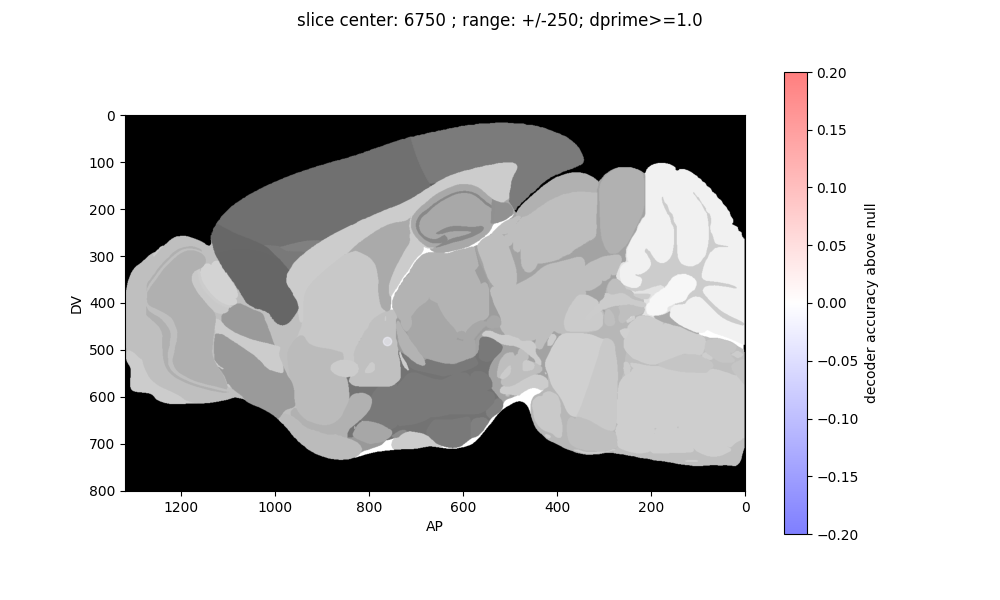

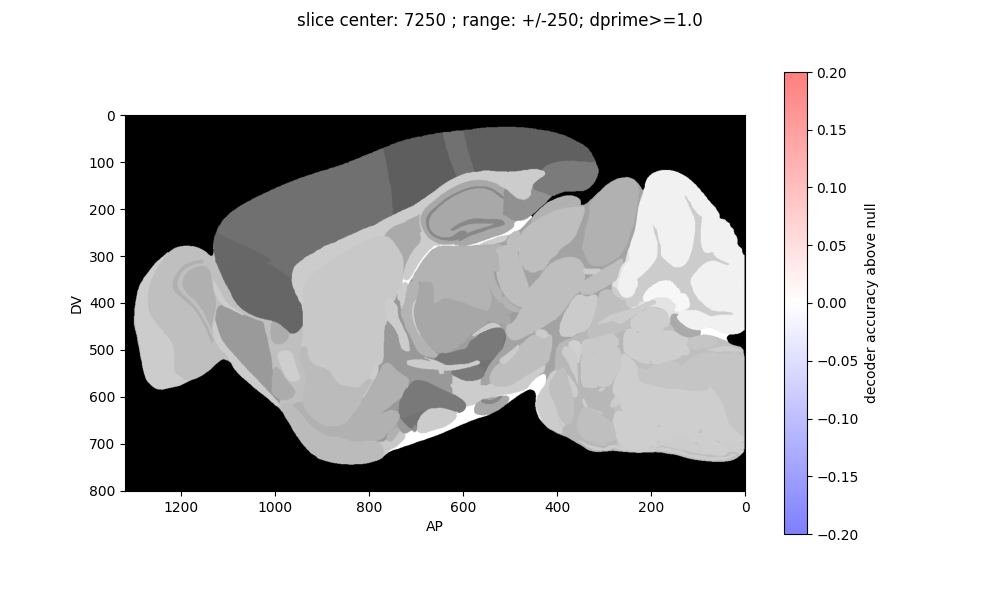

In [22]:
# plot all slices
dprime_thresh=1.0
slice_size=500
slice_pos_array=np.arange(slice_size/2,8000,slice_size)
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2024-05-21-decoding_topography"

for slice_pos in slice_pos_array:
    slice_image= rsp.get_slice_image(2, slice_pos)
    results= ccf_coords_by_session_area.query('ccf_ml_mean >= @slice_pos-@slice_size/2 and ccf_ml_mean <= @slice_pos+@slice_size/2 and \
                                               cross_modal_dprime>=@dprime_thresh and project=="DynamicRouting" and area!="all"')

    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    gray_image = rgb2gray(slice_image) 

    fig = plt.figure(figsize=(10,6))
    ax=plt.subplot(1,1,1)
    ax.imshow(gray_image.T,extent=[1320,0,800,0],cmap='gray') 

    points=ax.scatter(1320-results['ccf_ap_mean']/10,results['ccf_dv_mean']/10,c=results['true_accuracy']-results['null_accuracy_median'],alpha=0.5,cmap='bwr',vmin=-0.2,vmax=0.2)
    ax.set_xlabel('AP')
    ax.set_ylabel('DV')
    fig.colorbar(ax=ax,mappable=points,label='decoder accuracy above null')
    fig.suptitle('slice center: '+str(int(slice_pos))+' ; range: +/-'+str(int(slice_size/2))+'; dprime>='+str(dprime_thresh))

    # filesavepath=os.path.join(savepath,'sagittal_slice_'+str(int(slice_pos))+'.png')
    # plt.savefig(filesavepath,dpi=300)
    # plt.close(fig)